# Analysis of the response of olfactory receptors to VOC

## Dataset presentation
### Experimental protocol
- HELA cells were genetically engineered to express a mammalian olfactory receptor on their surface (OR1).
- They also express a range in of proteins allowing their fluorescence level to be correlated to the level of activation this olfactory receptor.
- A population of cells is kept in an incubator in DMSO and maintained for several days before they are dispensed into the wells of a 96-wells plate.
- The plate is inserted into a machine recording fluorescence over time.
- After a few seconds of recording, a certain volume of liquid compounds (VOC: Volatile organic compounds) is dispensed into each well.

### Data organization
The resulting recording files are available in the `data` folder. It contains:
- `plate_map_XXX.csv`: For each well, the olfactory receptor expressed by the HELA cells as well as the injected compound and its concentration (DMSO is a negative control).
- `parameters.txt`: A small text file containing a few acquisition parameters.
- `fluo_data_XX.csv`: The resulting fluorescence versus time for well XX.

### Goal
Our objective is here to determine if the olfactory receptor OR1 is activated by one of the compounds used during the experiment. 

## Data Parsing

In [1]:
# Import the main libraries we will use here
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# Data directory
data_dir = Path.cwd() / "data"

### Parameters
Extract the stimulation time (`TransferTime`) and the number of points for each time series (`NPoints`) from parameters.txt, you can for instance use regular expressions.

In [3]:
# Read the content of parameters.txt
parameters_path = data_dir / "parameters.txt"
with parameters_path.open("r") as f:
    parameters_content = f.readlines()
    
parameters_content

['ReadMode="Fluorescence"\n',
 'PlateType="96WP black bottom"\n',
 'TimeTagged="True"\n',
 'Name="Fam1-DoseResponseTest"\n',
 'ReadTime="3:36 PM 9/27/2020"\n',
 'RunTime="2:00"\n',
 'KineticInterval="1.600"\n',
 'NPoints="76"\n',
 'Excitation="430"\n',
 'Emission="485"\n',
 'TransferTime="19"\n',
 'Rate="1"\n',
 'Volume="10"\n',
 'PipetteHeight="80"']

In [4]:
# Parse the parameters file
parameters = {}
param_pattern = '(?P<name>\w+)="(?P<value>.+)"\n?'
for line in parameters_content:
    my_match = re.search(param_pattern, line)
    if my_match:
        line_parsed = my_match.groupdict()
        parameter_name = line_parsed["name"]
        parameter_value = line_parsed["value"]
        parameters[parameter_name] = parameter_value

parameters

{'ReadMode': 'Fluorescence',
 'PlateType': '96WP black bottom',
 'TimeTagged': 'True',
 'Name': 'Fam1-DoseResponseTest',
 'ReadTime': '3:36 PM 9/27/2020',
 'RunTime': '2:00',
 'KineticInterval': '1.600',
 'NPoints': '76',
 'Excitation': '430',
 'Emission': '485',
 'TransferTime': '19',
 'Rate': '1',
 'Volume': '10',
 'PipetteHeight': '80'}

In [5]:
n_points = int(parameters["NPoints"])
stim_time = float(parameters["TransferTime"])

### Fluorescence and time data
Select the files corresponding to fluorescence data (E.G. using a regular expression on the file name) and create two pandas DataFrame with rows corresponding to the time index and columns corresponding to each well with content:

- A first dataframe containing the time data for each well
- A second dataframe containing the fluorescence data for each well

In [6]:
# Create the names of  the columns
plate_columns = ["A", "B", "C", "D", "E", "F", "G", "H"]
plate_rows = [str(i) for i in range(1, 13)]
plate_wells = [c + r for c in plate_columns for r in plate_rows]

print(plate_wells)

['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12']


In [7]:
# Preallocate the time and fluorescence dataframes
time_df = pd.DataFrame(columns = plate_wells, index=np.arange(n_points))
fluo_df = pd.DataFrame(columns=plate_wells, index=np.arange(n_points))

# Loop over the fluorescence files and store their content in the dataframes
for path in data_dir.iterdir():
    file_name = path.name
    my_match = re.search("fluo_data_(?P<plate_column>[A-H])(?P<plate_row>\d{1,2}).csv", file_name)
    if path.is_file() and my_match:  # Filter the files matching the pattern
        # Use the file name to grab the well name
        parsed_name = my_match.groupdict()
        well = parsed_name["plate_column"] + parsed_name["plate_row"]
        # read the csv file
        data = pd.read_csv(path)
        # Add the data to the time and fluorescence dataframes
        time_df[well] = data["time"]
        fluo_df[well] = data["raw_data"]

In [8]:
fluo_df

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12
0,58.784,55.740,56.095,56.594,53.242,56.098,56.931,64.421,59.852,49.694,...,48.731,50.631,52.379,51.886,53.712,56.957,71.374,78.538,59.955,53.829
1,59.965,55.837,56.873,56.292,53.780,55.965,56.694,65.200,60.470,50.127,...,48.857,49.978,52.130,51.618,53.458,56.076,71.032,79.228,59.991,53.013
2,59.846,55.051,56.513,56.239,53.765,55.444,55.881,65.260,60.671,49.511,...,49.484,51.530,52.629,52.000,53.925,56.791,71.106,79.806,59.178,54.186
3,59.772,54.822,57.375,57.540,53.992,55.286,56.859,65.874,60.080,50.223,...,50.200,51.644,52.783,51.473,52.741,55.984,72.379,80.520,59.660,54.259
4,59.906,53.970,58.604,57.325,53.312,56.105,56.136,65.830,59.766,48.843,...,48.659,50.437,52.213,52.144,53.716,57.124,71.000,79.507,59.789,53.616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,118.788,104.700,109.744,110.770,59.538,62.318,63.074,69.715,60.584,53.085,...,54.499,53.929,56.851,55.678,56.872,60.639,73.731,83.974,63.688,56.208
72,118.951,104.598,109.085,110.541,60.265,61.828,63.742,69.998,60.418,53.535,...,54.822,54.399,56.244,54.075,56.918,60.023,74.041,82.557,63.542,56.986
73,118.600,104.678,108.645,109.769,60.170,62.811,63.288,69.206,61.783,53.253,...,53.517,54.637,56.947,55.385,56.726,59.760,74.109,81.386,63.401,56.461
74,115.142,105.484,109.029,109.409,60.599,62.151,62.885,68.847,59.893,53.119,...,53.994,54.051,56.768,54.839,57.223,59.751,74.422,81.787,63.003,55.301


### Plate maps
Read the metadata contained in `plate_map.csv` and create a pandas DataFrame containing one row per well and the following columns:

    - The well number as index (E.G. "A1")
    - The letter corresponding to the row on the plate (E.G. "A")
    - The number corresponding to the column on the plate (E.G. 1)
    - The name of the olfactory receptor
    - The compound (VOC)
    - The concentration

In [49]:
# Create the plate map dataframe using the wells' names as index
plate_map = pd.DataFrame(index=plate_wells)

# Grab the column and row corresponding to the well and add them to the dataframe
plate_row = [w[0] for w in plate_wells]  # Grab the letter corresponding to the row on the 96-wells plate
plate_col = [int(w[1:]) for w in plate_wells]  # idem with the number corresponding to the column 
plate_map["plate_col"] = plate_col
plate_map["plate_row"] = plate_row

plate_map

,plate_col,plate_row
A1,1,A
A2,2,A
A3,3,A
A4,4,A
A5,5,A
...,...,...
H8,8,H
H9,9,H
H10,10,H
H11,11,H


In [52]:
# Read the OR CSV and add its content to plate_map
plate_map["OR"] = ""

or_path = data_dir / "plate_map_OR.csv"
or_df = pd.read_csv(or_path, index_col="OR")

for row in or_df.index:
    for col in list(or_df):
        plate_map.loc[row + col, "OR"] = or_df.loc[row, col]

In [53]:
# Read the VOC CSV and add its content to plate_map
plate_map["VOC"] = ""

voc_path = data_dir / "plate_map_VOC.csv"
voc_df = pd.read_csv(voc_path, index_col="VOC")

for row in voc_df.index:
    for col in list(voc_df):
        plate_map.loc[row + col, "VOC"] = voc_df.loc[row, col]

In [54]:
# Read the concentration CSV and add its content to plate_map
plate_map["C"] = 0.
index_col = "[final C] in M"

concentration_path = data_dir / "plate_map_concentration.csv"
concentration_df = pd.read_csv(concentration_path, index_col=index_col)

for row in concentration_df.index:
    for col in list(concentration_df):
        plate_map.loc[row + col, "C"] = concentration_df.loc[row, col]

In [55]:
plate_map

,plate_col,plate_row,OR,VOC,C
A1,1,A,OR1,Menthol,0.00001
A2,2,A,OR1,Menthol,0.00001
A3,3,A,OR1,Menthol,0.00001
A4,4,A,OR1,Menthol,0.00001
A5,5,A,OR1,Pinene,0.00010
...,...,...,...,...,...
H8,8,H,OR1,Pinene,0.00000
H9,9,H,OR1,DMSO,0.00000
H10,10,H,OR1,DMSO,0.00000
H11,11,H,OR1,DMSO,0.00000


## Computation of a metric indicating the level of activation the olfactory receptor
### Visualization of the time series
For a selected well, plot the raw fluo fluorescence versus time



Text(0.5, 1.0, 'Fluorescence data for well A1\nOR1, Menthol at 1e-05M')

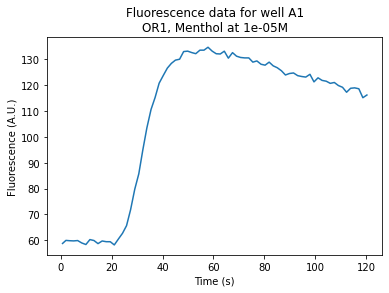

In [56]:
well = "A1"
fig, ax = plt.subplots()
ax.plot(time_df[well], fluo_df[well])
ax.set_xlabel("Time (s)")
ax.set_ylabel("Fluorescence (A.U.)")
ax.set_title(f"Fluorescence data for well {well}\n"
             f"{plate_map.loc[well, 'OR']}, {plate_map.loc[well, 'VOC']} at {plate_map.loc[well, 'C']}M")

In [57]:
plate_map

,plate_col,plate_row,OR,VOC,C
A1,1,A,OR1,Menthol,0.00001
A2,2,A,OR1,Menthol,0.00001
A3,3,A,OR1,Menthol,0.00001
A4,4,A,OR1,Menthol,0.00001
A5,5,A,OR1,Pinene,0.00010
...,...,...,...,...,...
H8,8,H,OR1,Pinene,0.00000
H9,9,H,OR1,DMSO,0.00000
H10,10,H,OR1,DMSO,0.00000
H11,11,H,OR1,DMSO,0.00000


### Write a function to compute the AUC on our data
The Area Under the Curve (AUC) is a common metric used to measure the level of activation of a protein to a particular compound. After subtracting the baseline, it is simply defined as the sum of a signal's after a stimulation times the width of the window:


<img src="ressources/AUC.png" width="600">

The stimulation can create a small artefact, we therefore only consider the fluorescence after a short time delay after the stimulation.

In [58]:
def compute_baseline(fluo, time, stim_time):
    "Compute the baseline for a fluorescence time series"
    is_before_stim = time < stim_time
    return fluo[is_before_stim].mean()


def auc(fluo, time, stim_time, delay_after_stim=0.):
    """Compute the AUC for a fluorescence  time series.
    
    Parameters
    ----------
    fluo, array
        The fluorescence data
    
    time, array
        The associated timestamps (same length as fluo)
    
    stim_time, float
        The stimulation time.
    
    delay_after_stim, float (default: 0.)
        A short time delay after the stimulation time that will be
        ignored when computing the AUC to avoid the stimulation artifact
        to have an effect on the result. 
    
    Returns
    -------
    float,
        The area under the curve
    
    """
    baseline = compute_baseline(fluo, time, stim_time)
    # Sum the fluorescence after the stimulation time
    is_after_stim = time > stim_time + delay_after_stim
    fluo_subtracted_baseline = fluo - baseline
    summed_fluo =  fluo_subtracted_baseline[is_after_stim].sum()
    # Width of the interval in seconds
    width = time[-1] - time[is_after_stim][0]
    
    # return the auc
    return width * summed_fluo

In [59]:
# Let's test it on one well
well = "A1"
fluo = fluo_df[well].values
time = time_df[well].values

In [60]:
compute_baseline(fluo, time, stim_time)

59.48091666666667

In [61]:
auc(fluo, time, stim_time, delay_after_stim=1.)

370390.7336447999

## Computation of the AUC for all wells
Add a column corresponding to the AUC in the DataFrame created from the plate map file

In [62]:
plate_map["AUC"] = 0

for well in plate_map.index:
    fluo = fluo_df[well].values
    time = time_df[well].values
    plate_map.loc[well, "AUC"] = auc(fluo, time, stim_time, delay_after_stim=1.)
plate_map

,plate_col,plate_row,OR,VOC,C,AUC
A1,1,A,OR1,Menthol,0.00001,370390.733645
A2,2,A,OR1,Menthol,0.00001,315984.220877
A3,3,A,OR1,Menthol,0.00001,318452.507290
A4,4,A,OR1,Menthol,0.00001,340731.879322
A5,5,A,OR1,Pinene,0.00010,42297.757632
...,...,...,...,...,...,...
H8,8,H,OR1,Pinene,0.00000,36221.098121
H9,9,H,OR1,DMSO,0.00000,32457.621879
H10,10,H,OR1,DMSO,0.00000,33534.504209
H11,11,H,OR1,DMSO,0.00000,40162.868053


### Dose response
For each compound, plot the dose response curves (AUC versus concentration) associated with the corresponding columns of the 96-wells plate.

**Bonus** You can replace the individual traces for each compound by an average and error bars corresponding for instance to the standard deviation.

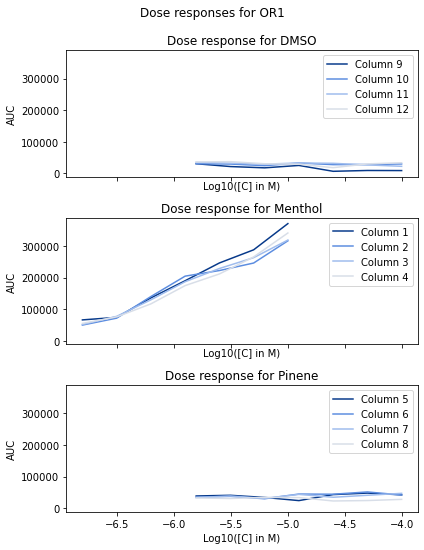

In [63]:
# HEX code for the colors of the lines
colors = ["#07398a", "#5c8de0", "#9fbced", "#d8dee8"]

fig, axs = plt.subplots(3, 1, figsize=(6, 8), sharex=True, sharey=True)
# Loop over the compounds
for i, compound in enumerate(np.unique(plate_map.VOC)):
    # Filter the data, here we simply discard the wells where the concentration is 0
    # N.B. We could instead plot the AUC divided by the AUC obtained for a concentration of 0
    selected_data = plate_map[(plate_map.VOC == compound) & (plate_map.C != 0)]
    
    selected_plate_columns = np.unique(selected_data.plate_col)
    ax = axs[i]  # Select the ax on which the data will be plotted
    for j, col in enumerate(selected_plate_columns):
        # Select the data to plot
        log_c = np.log10(selected_data[selected_data.plate_col == col].C)  # log concentration
        auc_to_plot = selected_data[selected_data.plate_col == col].AUC  # AUC
        # Plot the data
        ax.plot(log_c, auc_to_plot, label=f"Column {col}", c=colors[j])
        ax.legend()
        ax.set_title(f"Dose response for {compound}")
        ax.set_ylabel("AUC")

    ax.set_xlabel("Log10([C] in M)")
fig.suptitle(f"Dose responses for {plate_map.OR[0]}")
# Make the figure a bit nicer
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

## To go further
**Bonus** Select an appropriate statistical test and use statsmodels to conclude on the activation of the olfactory receptor by menthol and pinene.

In [21]:
import statsmodels